In [1]:
import pickle
from tqdm.notebook import tqdm
import pandas as pd
import random
import tensorflow as tf
import numpy as np

In [2]:
#set the ransom seed to have reproducible results
random.seed(42)
tf.random.set_seed(42)
np.random.seed(42)

In [3]:
data_path = 'data/'
pickle_path = 'pickle/'

In [4]:
#get the dataframe from the pickle stored in previous notebook
with open(pickle_path + 'stories_df.pkl','rb') as file:
    df = pickle.load(file)
    
df.head(5)

,story_id,sentence_id,sentence,label
0,0,0,at the start of a big week for the higgs boson...,0
1,0,1,the scientists outlined their final analysis b...,0
2,0,2,what is the higgs boson and why is it important,0
3,0,3,their announcement came two days before resear...,0
4,0,4,our data strongly point toward the existence o...,0


In [5]:
#view some basic statistics of the data
df_temp = df.groupby(by='story_id',as_index=False).count()[['story_id','sentence_id']]
print(df_temp.info())
print("---------------")
print(df_temp.describe())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 92465 entries, 0 to 92464
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   story_id     92465 non-null  int64
 1   sentence_id  92465 non-null  int64
dtypes: int64(2)
memory usage: 2.1 MB
None
---------------
           story_id   sentence_id
count  92465.000000  92465.000000
mean   46289.515947     21.333683
std    26726.811213     11.713029
min        0.000000      1.000000
25%    23145.000000     13.000000
50%    46290.000000     19.000000
75%    69433.000000     27.000000
max    92578.000000    352.000000


No. of stories - 92465
75% of the stories are less 27 in length (story length = no. of sentences in the story), let's view the distribution

In [6]:
#get the stories which have length less than 30
dfs = df_temp[df_temp['sentence_id'] < 30]
print("total stories:",len(dfs))

#get 50K stories out of the above
dfs = dfs.sample(n=50000)

#split in train, validate and test
df_train = dfs[:30000]
df_val = dfs[30000:40000]
df_test = dfs[40000:]

#get the rows with the above story ids from the main dataframe
df_train = df[df['story_id'].isin(list(df_train['story_id']))]
df_val = df[df['story_id'].isin(list(df_val['story_id']))]
df_test = df[df['story_id'].isin(list(df_test['story_id']))]

total stories: 74220


In [7]:
#store in file system as csv
df_train.to_csv(data_path + 'train.csv')
df_val.to_csv(data_path + 'val.csv')
df_test.to_csv(data_path + 'test.csv')

In [8]:
df1 = df_train.groupby(by='story_id',as_index=False).count()[['story_id','sentence_id']]
df1.rename(columns={'sentence_id':'story_length'},inplace=True)

df2 = df_train.copy()
df2['sentence_length'] = df2['sentence'].apply(lambda x:len(x.split()))

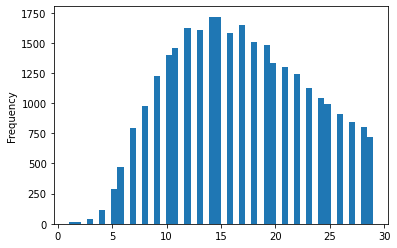

In [9]:
#plot the story length
df1.story_length.plot.hist(bins=50);

In [10]:
df1.story_length.describe()

count    30000.000000
mean        16.839600
std          6.228469
min          1.000000
25%         12.000000
50%         16.000000
75%         22.000000
max         29.000000
Name: story_length, dtype: float64

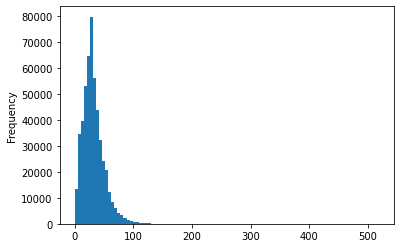

In [11]:
#plot the sentence length
df2.sentence_length.plot.hist(bins=100);

In [12]:
df2.sentence_length.describe()

count    505188.000000
mean         31.592126
std          18.159800
min           0.000000
25%          19.000000
50%          29.000000
75%          41.000000
max         519.000000
Name: sentence_length, dtype: float64

In [57]:
max_story_length = df1.story_length.max()
print("max story length:", df1.story_length.max())
print("max sentence length:", df2.sentence_length.max())

max story length: 29
max sentence length: 519


In [36]:
#create a label to index dictionary. add PAD for index 0
label2idx = {idx:val+1 for idx, val in enumerate(df_train.label.unique())}
label2idx['PAD'] = 0

print(label2idx)

{0: 1, 1: 2, 'PAD': 0}


In [49]:
#retrieve all unique words
sentences = (' ').join(list(df_train.sentence.values))
words = list(set(sentences.split()))
words.sort()
len(words)

166675

In [53]:
#create word to index dictionary
word2idx = {word:i+2 for i, word in enumerate(words)}
word2idx['UNK'] = 1
word2idx['PAD'] = 0

#create index to word dictionary
idx2word = {v:k for k, v in word2idx.items()}

In [58]:
#save label2idx, word2idx and idx2word

with open(pickle_path + 'label2idx.pkl','wb') as fl:
    pickle.dump(label2idx, fl)

with open(pickle_path + 'word2idx.pkl','wb') as fl:
    pickle.dump(word2idx, fl)

with open(pickle_path + 'idx2word.pkl','wb') as fl:
    pickle.dump(idx2word, fl)

In [59]:
#set the max sentence length at 40
max_sentence_length = 40

In [63]:
#encode the sentences with max length of max_sentence_length
def pad_encode_sentences(df):
    df = df.groupby('story_id').agg({'sentence':','.join})
    pad_enc_sentences = []
    for sentences in tqdm(list(df.sentence)):
        enc_sent = [[word2idx.get(w,1) for w in sent.split()[:max_sentence_length]] for sent in sentences.split(',')]
        if len(enc_sent) < max_story_length:
            enc_sent.extend([[0 for p in range(max_sentence_length)] for i in range(max_story_length - len(enc_sent))])
        padded_sen = tf.keras.preprocessing.sequence.pad_sequences(enc_sent,maxlen = max_sentence_length,padding='post',truncating='post')
        pad_enc_sentences.append(padded_sen)
    return pad_enc_sentences

In [64]:
#pad the labels with max length of story
def pad_labels(df):
    dfx = df.copy()
    dfx['label'] = dfx['label'] + 1
    dfx = dfx[['story_id','label']].groupby('story_id').agg(lambda col: col.tolist()).reset_index()
    labels = tf.keras.preprocessing.sequence.pad_sequences(list(dfx.label),maxlen = max_story_length, padding='post',truncating='post')
    labels = labels.reshape(-1, max_story_length, 1)
    return labels

In [65]:
pad_enc_sentences_train = pad_encode_sentences(df_train)
pad_enc_sentences_val = pad_encode_sentences(df_val)
pad_enc_sentences_test = pad_encode_sentences(df_test)

pad_enc_sentences_train = np.array(pad_enc_sentences_train)
pad_enc_sentences_val = np.array(pad_enc_sentences_val)
pad_enc_sentences_test = np.array(pad_enc_sentences_test)

padded_labels_train = pad_labels(df_train)
padded_labels_val = pad_labels(df_val)
padded_labels_test = pad_labels(df_test)

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [66]:
with open(pickle_path + 'padded_data_train.pkl', 'wb') as fl:
    pickle.dump(pad_enc_sentences_train,fl)

with open(pickle_path + 'padded_data_val.pkl', 'wb') as fl:
    pickle.dump(pad_enc_sentences_val,fl)

with open(pickle_path + 'padded_data_test.pkl', 'wb') as fl:
    pickle.dump(pad_enc_sentences_test, fl)

with open(pickle_path + 'padded_labels_train.pkl', 'wb') as fl:
    pickle.dump(padded_labels_train,fl)

with open(pickle_path + 'padded_labels_val.pkl', 'wb') as fl:
    pickle.dump(padded_labels_val,fl)

with open(pickle_path + 'padded_labels_test.pkl', 'wb') as fl:
    pickle.dump(padded_labels_test, fl)